In [1]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import importlib
from tqdm.notebook import tqdm
import time
import pandas as pd
import logging

from topostats.filters import Filters
from topostats.grains import Grains
from topostats.grainstats import GrainStats
from topostats.io import find_files, read_yaml, write_yaml, LoadScans
from topostats.logs.logs import setup_logger, LOGGER_NAME
from topostats.utils import update_config

In [41]:
# assuming linedetection.py is in parent directory of data 
#MOD_DIR=Path(os.getenv('REPO')).joinpath('line_detection')
#sys.path.append(MOD_DIR)
import linemol
importlib.reload(linemol)
from linemol import Molecule, LineDetection, Line, SpmPlot

In [39]:
logger = logging.getLogger(LOGGER_NAME)
logger.setLevel(logging.CRITICAL)  # without printing logs
#logger.setLevel(logging.INFO)  # with printing infologs
#logger.setLevel(logging.DEBUG) # with verbose logs

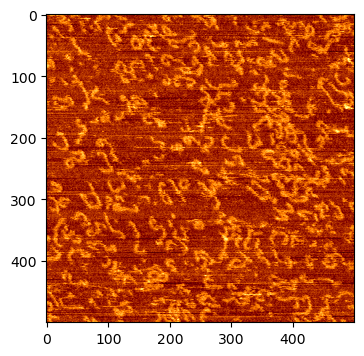

In [22]:
# Set BASE_DIR containing a file and config.yaml
BASE_DIR=Path(os.getcwd())
FILE_EXT = ".gwy"
##############################
#IMG_KEY = "PO-Wavemode500"
#CONFIG = "config_PO.yaml"
##############################
IMG_KEY = "PL-Wavemode500"
CONFIG = "config_PL.yaml"
##############################
IMG_FILES = [BASE_DIR.joinpath('data').joinpath(IMG_KEY+".gwy"),]

config = read_yaml(BASE_DIR.joinpath('data').joinpath(CONFIG))
loading_config = config["loading"]
filter_config = config["filter"]
filter_config.pop("run")
grain_config = config["grains"]
grain_config.pop("run")
loaded_data = LoadScans(IMG_FILES, **config["loading"])
loaded_data.get_data()

# Plot the loaded scan in its raw format
aspect = loading_config["scale"]["xy_aspect"]
SpmPlot.image(loaded_data.image, cmap="afmhot", aspect=aspect)

In [23]:
# Filter
filtered_image = Filters(
        image=loaded_data.img_dict[IMG_KEY]["image_original"],
        filename=loaded_data.img_dict[IMG_KEY]["img_path"],
        pixel_to_nm_scaling=loaded_data.img_dict[IMG_KEY]["pixel_to_nm_scaling"],
        **filter_config,)
filtered_image.filter_image()

Available NumPy arrays to plot in filter_image.images dictionary :

dict_keys(['pixels', 'initial_median_flatten', 'initial_tilt_removal', 'initial_quadratic_removal', 'initial_scar_removal', 'masked_median_flatten', 'masked_tilt_removal', 'masked_quadratic_removal', 'secondary_scar_removal', 'scar_mask', 'mask', 'zero_average_background', 'gaussian_filtered', 'initial_nonlinear_polynomial_removal', 'masked_nonlinear_polynomial_removal'])


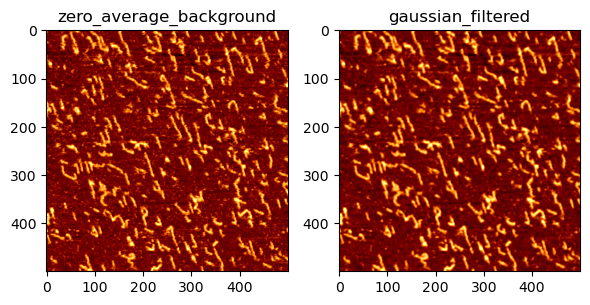

In [85]:
print(f"Available NumPy arrays to plot in filter_image.images dictionary :\n\n{filtered_image.images.keys()}")
SHOW_TILE = True
if SHOW_TILE:
    keys = ['zero_average_background','gaussian_filtered']
    SpmPlot.tile_images(filtered_image.images, image_keys=keys, cmap="afmhot")

# Find grains

Here polymer chains are detected by using Grains of Topostats. Resulting Numpy array of "labelled_regions_02" conatins index label starting from 1 for all polymer chains. 

In [24]:
grains = Grains(
                image=filtered_image.images["zero_average_background"],
                filename=filtered_image.filename,
                pixel_to_nm_scaling=filtered_image.pixel_to_nm_scaling,
                **grain_config,
                )
grains.find_grains()

method = grain_config["threshold_method"]
threshold = grain_config["threshold_std_dev"]["above"]
print(f"Method: {method}, threshold: {threshold}")
print(f"Resulting image keys above threshold:\n {grains.directions['above'].keys()}")

lbl1 = grains.directions['above']['labelled_regions_01']
lbl2 = grains.directions['above']['labelled_regions_02']
(lbl1_count,lbl2_count) = (lbl1.max(), lbl2.max())
lbl_grains = {
    f'lbl1 ({lbl1_count})':lbl1, 
    f'lbl2 ({lbl2_count})':lbl2,
}
SHOW_LABELLED = False
if SHOW_LABELLED:
    tile_images(lbl_grains, cmap='afmhot')

Method: std_dev, threshold: 1.2
Resulting image keys above threshold:
 dict_keys(['mask_grains', 'labelled_regions_01', 'tidied_border', 'removed_noise', 'removed_small_objects', 'labelled_regions_02', 'coloured_regions'])


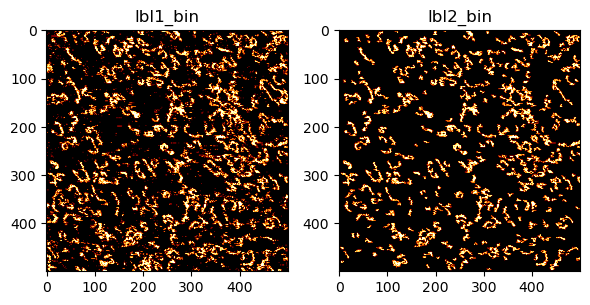

In [25]:
lbl1_bin = lbl1.astype(dtype=bool).astype(dtype=np.int32)
lbl2_bin = lbl2.astype(dtype=bool).astype(dtype=np.int32)
bin_grains = {"lbl1_bin":lbl1_bin, "lbl2_bin":lbl2_bin}
SpmPlot.tile_images(bin_grains, cmap="afmhot")

# Line detection

Linemol module is for detection of linear part of polymer chain of SPM height data. Principle of this analysis is to score all possible lines in a molecule. The score is calculated from the sum of the height values of the pixels that make up the line.

This module has three classes to handle data processing.
- **`Line`** - contains pixel positions of a line
- **`Molecule`** - contains a molecule from preceding grain analysis
- **`LineDetection`** - tools to analyse linear part of molecules to generate results as Pandas.DataFrame

## Data import and filtering by Topostats
Topostats is a Python library for topological data analysis. It provides a set of tools for analyzing and visualizing topological data, such as persistent homology, persistent diagrams, and other related techniques. It is designed to be easy to use and extend, and is suitable for both research and educational purposes. Filtering and finding grains from a Gwyddion file are conducted by Topostats software program. 

## Molecule class
Pixels of each molecule are obtained from grains.directions["above"]["labelled_regions_02"]. A class of `LineDetection` handles the labelled regions ndarray. All molecules are stored as `Molecule` object that provide positions, vectors generated from the positions, methods for detection of linear part.

## Processing
Number of all possible vectors in a molecule sometimes comes enormous, so several steps are implemented to reduce unnecessary lines.

### Qudrants and length filtering
vector pairs are filtered by direction and length. The minimum and maximum length are defined as `min_len` and `max_len` in a config dict.
-  Exclude vectors from the set that are facing the third and fourth quadrants.
-  Exclude vectors exceeding provided minimum and maximum length

### Empty pixel(s) along a line
After collecting the set of vectors, a synthetic straight line is drawn in 2D binary array. When original binary data has gaps along the synthetic line, it is considered to have 'empty' pixels. A line with large number of empty pixels are excluded because it should not be regard as a straight and continuous line. The maximum pixel number is defined as `allowed_empty` in a config dict.

Resulting lines are stored as DataFrame of pandas. Initial dataframe has columns of `mol_idx`, `score`, `pix1`, `pix2`, `angle`

### Overlapping lines
(Not implemented yet) Some lines are covered with a longer line completely, others are covered partially. Shorter and lines with lower score that is covered with other line can be eliminated. In order to prioritize score, dataframe was sorted descending by `score` column.



In [26]:
source = filtered_image.images["gaussian_filtered"]
config = {"min_len":7, "max_len":20,"allowed_empty":1, "use_cache":True}

ld = LineDetection(lbl2, source, **config)

In [27]:
count = 0
time0 = time.perf_counter()
for i in tqdm(range(len(ld.molecules))):
    mol = ld.molecules[i]
    filtered = ld.filter_by_length(mol)
    if filtered is not None:
        lines_cnt = ld.score_lines(mol, filtered)
        if lines_cnt > 0:
            count += 1
time1 = time.perf_counter()
duration = time1 - time0
print(f"{count} molecules calculated in {duration:.3f}")
total_row = len(ld.score_df)
print(f'Total {total_row} rows recorded in score_df.')

  0%|          | 0/419 [00:00<?, ?it/s]

388 molecules calculated in 49.112
Total 21300 rows recorded in score_df.


In [28]:
# ld.config["score_cutoff"]
(hit, total) = ld.line_cache_hit
hit_rate = 100 * hit / total
cache_size = sys.getsizeof(ld.line_cache) / 1000000
print(f'{total} lines were cached ({cache_size:.1f} MB), hit {hit}({hit_rate:.1f}%) during calculation.')

719557 lines were cached (10.5 MB), hit 447597(62.2%) during calculation.


In [29]:
# Save as pickle
SAVE_FILE = True
LOAD_FILE = False
prefix = f'{IMG_KEY}_{config["min_len"]}_{config["max_len"]}_{config["allowed_empty"]}_'

if SAVE_FILE:
    ld.score_df.to_pickle(prefix + "score_df.pkl.gz")
    ld.stat_df.to_pickle(prefix + "stat_df.pkl.gz")

if LOAD_FILE:
    score_df = pd.read_pickle(prefix + "score_df.pkl.gz")

In [77]:
# sys.getsizeof(ld.score_df)

In [30]:
# Result of line detection is in score_df
found_mol_count = len(ld.score_df.loc[ld.score_df["score"]>0].groupby("mol_idx").count())
print(f"{found_mol_count} molecules estimated (score > 0)")
maximum_length = ld.score_df.loc[ld.score_df["score"]>0]["length"].max()
print(f"Maximum length was {maximum_length:.2f}")
ld.score_df.loc[ld.score_df["score"]>0].sort_values("length", ascending=False)

351 molecules estimated (score > 0)
Maximum length was 20.00


,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score
1735,43,7.470850,1,8,10,20,26,20.0,53.130102,2.932461
7222,148,6.801451,1,24,8,36,24,20.0,53.130102,1.540428
1734,43,7.681800,1,8,9,20,25,20.0,53.130102,3.118360
12968,234,6.730994,1,9,8,25,20,20.0,36.869898,2.295927
15519,271,6.286709,1,4,9,20,21,20.0,36.869898,3.259311
...,...,...,...,...,...,...,...,...,...,...
20642,408,3.024875,0,1,2,8,2,7.0,0.000000,1.136705
20283,396,3.527334,0,5,0,5,7,7.0,90.000000,1.302655
661,22,2.528744,0,0,3,7,3,7.0,0.000000,1.075451
7980,152,2.415368,0,1,1,8,1,7.0,0.000000,1.508359


In [79]:
# Filtering statistics is in stat_df
ld.stat_df.sort_values("pixels", ascending=False).head()

,mol_idx,pixels,total_vecs,len_filtered,total_lines,min_len,max_len,max_pix,score_cutoff
154,165,521,135460,0,NaN,7,20,500,NaN
143,153,502,125751,0,NaN,7,20,500,NaN
167,178,474,112101,39570,NaN,7,20,500,NaN
3,4,459,105111,50240,NaN,7,20,500,NaN
148,159,458,104653,48508,NaN,7,20,500,NaN


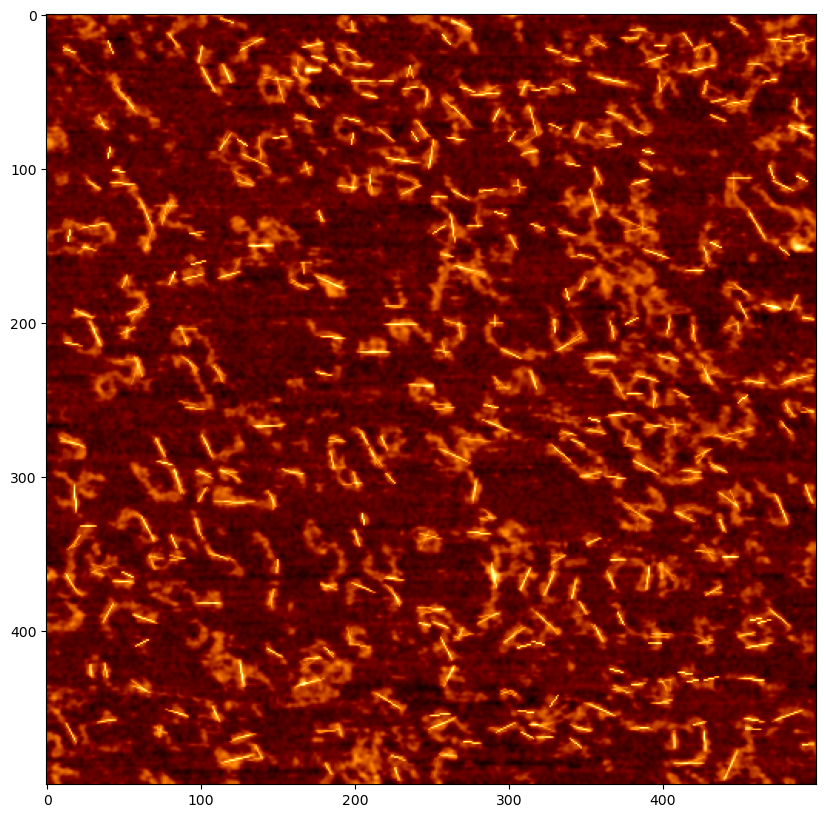

In [31]:
# Overlay
overlaid = ld.overlay_lines(num_lines=10, factor=200)
SpmPlot.image(overlaid, cmap="afmhot", figsize=(10,10))

In [33]:
sorted_df = ld.score_df.sort_values("norm_score",ascending=False)
sorted_df["angle_r1"] = sorted_df["angle"] - (sorted_df["angle"] % 1.0)
sorted_df["angle_r3"] = sorted_df["angle"] - (sorted_df["angle"] % 3.0)
sorted_df["angle_r5"] = sorted_df["angle"] - (sorted_df["angle"] % 5.0)


<AxesSubplot:xlabel='angle', ylabel='norm_score'>

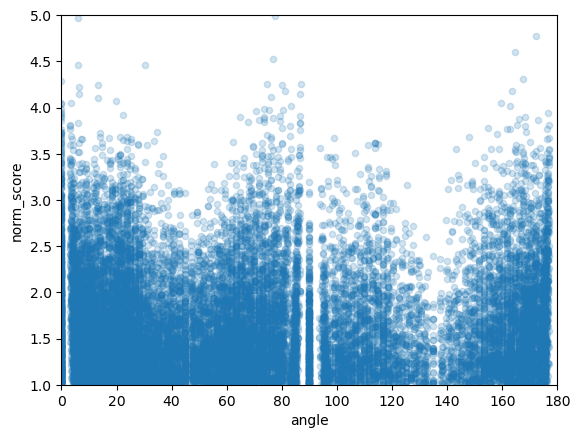

In [34]:
sorted_df[:].plot.scatter(x="angle", y='norm_score', alpha=0.2, xlim=(0,180), ylim=(1,5))


In [205]:
sorted_df

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score,angle_r1,angle_r3,angle_r5
28493,210,8.080264,1,13,3,11,22,19.104973,96.009006,4.812428,96.0,96.0,95.0
28494,210,8.055593,1,13,2,11,21,19.104973,96.009006,4.786451,96.0,96.0,95.0
3087,25,8.041146,0,5,9,24,11,19.104973,6.009006,4.651096,6.0,6.0,5.0
23633,180,7.226056,1,3,7,22,8,19.026298,3.012788,4.621540,3.0,3.0,0.0
18725,152,8.093434,0,0,1,19,7,19.924859,17.525568,4.519504,17.0,15.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32937,267,4.055661,0,7,2,5,12,10.198039,101.309932,1.000101,101.0,99.0,100.0
2849,22,3.463431,0,6,4,15,5,9.055385,6.340192,1.000046,6.0,6.0,5.0
16561,131,3.349517,1,5,11,10,20,10.295630,60.945396,1.000029,60.0,60.0,60.0
38400,317,4.254813,1,22,1,9,12,17.029386,139.763642,1.000025,139.0,138.0,135.0


In [35]:
def get_angle_dist(df,column="angle_r1"):
    angle = []
    angle_counts = []
    for a in range(180):
        angle_count = df.loc[df[column]==a].groupby("mol_idx").count().sum()
        if angle_count[0] == 0:
            continue
        angle.append(a)
        angle_counts.append(angle_count[0])
    return pd.DataFrame({"angle":angle, "counts":angle_counts})
#angle_dist1 = get_angle_dist(sorted_df,column="angle_r1")
angle_dist3 = get_angle_dist(sorted_df,column="angle_r3")
#angle_dist5 = get_angle_dist(sorted_df,column="angle_r5")

<AxesSubplot:xlabel='angle', ylabel='counts'>

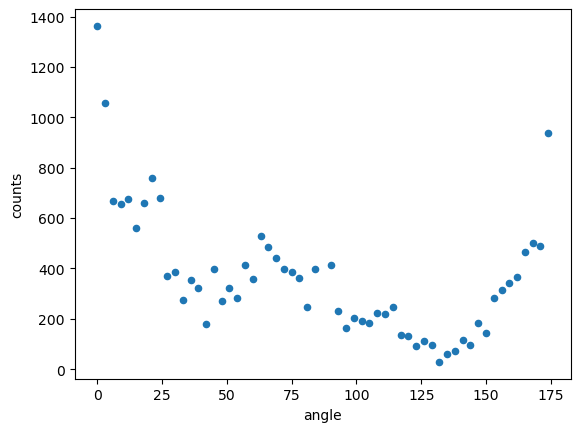

In [36]:
angle_dist3.plot.scatter(x="angle",y="counts")

In [37]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

def func(x, *params):

    #paramsの長さでフィッティングする関数の数を判別。
    num_func = int(len(params)/3)

    #ガウス関数にそれぞれのパラメータを挿入してy_listに追加。
    y_list = []
    for i in range(num_func):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])]
        ctr = params[int(param_range[1])]
        wid = params[int(param_range[2])]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
        y_list.append(y)

    #y_listに入っているすべてのガウス関数を重ね合わせる。
    y_sum = np.zeros_like(x)
    for i in y_list:
        y_sum = y_sum + i

    #最後にバックグラウンドを追加。
    y_sum = y_sum + params[-1]

    return y_sum

def fit_plot(x, *params):
    num_func = int(len(params)/3)
    y_list = []
    for i in range(num_func):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])]
        ctr = params[int(param_range[1])]
        wid = params[int(param_range[2])]
        y = y + amp * np.exp( -((x - ctr)/wid)**2) + params[-1]
        y_list.append(y)
    return y_list

In [38]:
#初期値のリストを作成
#[amp,ctr,wid]
guess = []
guess.append([1500, 20, 5])
guess.append([750, 60, 5])

#バックグラウンドの初期値
background = 5

#初期値リストの結合
guess_total = []
for i in guess:
    guess_total.extend(i)
guess_total.append(background)

###############################
x = angle_dist3["angle"]
y = angle_dist3["counts"]
popt, pcov = curve_fit(func, x, y, p0=guess_total)
###########################

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1600.

In [ ]:
popt,pcov

In [39]:
fit = func(x, *popt)
plt.scatter(x, y, s=20)
plt.plot(x, fit , ls='-', c='black', lw=1)

y_list = fit_plot(x, *popt)
baseline = np.zeros_like(x) + popt[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.6)

NameError: name 'popt' is not defined

In [189]:
ld.score_df.sort_values("norm_score",ascending=False)[10:1000].loc[(ld.score_df["norm_score"]>4) & (ld.score_df["angle"]>99)]

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score


# Normalized score

This normalization should be conducted for each molecule.

In [45]:
df = ld.score_df
mol_df = df.loc[(df["mol_idx"]==mol.mol_idx)].sort_values("norm_score",ascending=False)
mol_df[:3]

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score
279,13,6.564217,0,1,4,17,5,16.031220,3.576334,4.049204
280,13,6.259713,0,2,4,17,5,15.033296,3.814075,3.656120
281,13,5.896861,0,3,4,17,5,14.035669,4.085617,3.187713


# Checking an individual molecule

In [50]:
ld.score_df.loc[ld.score_df["norm_score"]>0].sort_values("norm_score",ascending=False)

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score
2756,67,7.422544,1,11,1,15,19,18.439089,77.471192,4.993644
1345,38,8.041146,0,4,9,23,11,19.104973,6.009006,4.965777
20252,393,5.869836,0,16,4,1,6,15.132746,172.405357,4.773111
19248,360,8.389692,1,25,12,7,17,18.681542,164.475889,4.598945
2757,67,7.029511,1,11,2,15,19,17.464249,76.759480,4.524025
...,...,...,...,...,...,...,...,...,...,...
12273,218,4.191388,0,14,4,6,5,8.062258,172.874984,1.000178
2016,43,5.278147,1,7,2,8,14,12.041595,85.236358,1.000144
3791,105,3.569508,1,2,2,6,11,9.848858,66.037511,1.000132
20329,399,4.376554,1,12,3,1,8,12.083046,155.556045,1.000089


In [51]:
def plot_emphasized_by_score(df, mol, ilocs, use_max=False):
    """ Plot an emphasized line in src image"""
    mol_score = df.loc[df["mol_idx"]==mol.mol_idx]
    if len(mol_score)==0:
        return
    line_mask = mol.get_blank()
    for iloc in ilocs:
        row = mol_score.iloc[iloc].tolist()
        (x1,y1,x2,y2) = tuple(row[3:7])
        l = Line.create_from_pos(x1,y1,x2,y2).get_mask(mol.height, mol.width)
        line_mask = line_mask + l
    line_mask = line_mask / (len(ilocs))
    emp = ld.get_emphasized(mol,line_mask,factor=1.5, use_max=True)
    plt.imshow(emp)
    plt.plot()


In [53]:
angle130 = ld.score_df.loc[(ld.score_df["angle"]>125) & (ld.score_df["angle"]<135)]

In [54]:
mol_idx = 67
mol = ld.molecules[mol_idx - 1]
plot_emphasized_by_score(angle130, mol,range(0,1))

In [55]:
angle130.groupby("mol_idx").count()

,score,empty,x1,y1,x2,y2,length,angle,norm_score
mol_idx,,,,,,,,,
18,14,14,14,14,14,14,14,14,14
29,12,12,12,12,12,12,12,12,12
35,1,1,1,1,1,1,1,1,1
38,1,1,1,1,1,1,1,1,1
47,1,1,1,1,1,1,1,1,1
51,1,1,1,1,1,1,1,1,1
78,3,3,3,3,3,3,3,3,3
86,5,5,5,5,5,5,5,5,5
104,1,1,1,1,1,1,1,1,1


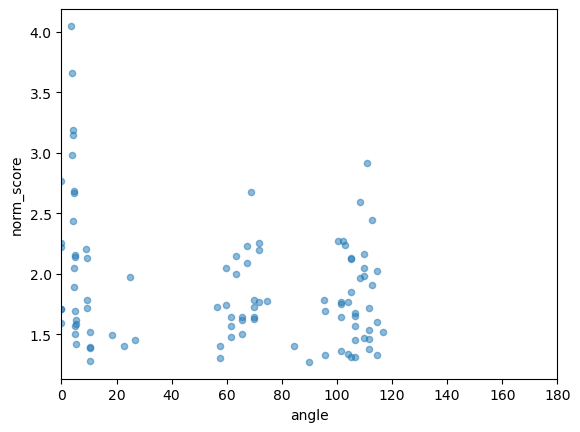

In [56]:
ret_mol = mol_df[0:100].plot.scatter(x="angle", y='norm_score', alpha=0.5, xlim=(0,180))

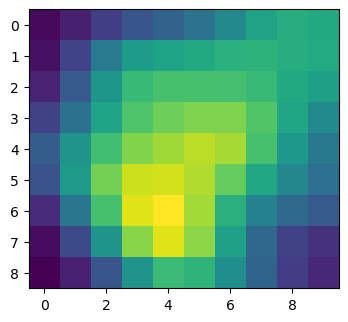

In [61]:
mol = ld.molecules[161]
max_z = mol.src_img.max()

SpmPlot.image(mol.src_img)

# Eliminate overlapping lines


In [15]:
score_df = pd.read_pickle('PO-Wavemode500_7_20_1_score_df.pkl.gz')
stat_df = pd.read_pickle('PO-Wavemode500_7_20_1_stat_df.pkl.gz')

In [22]:
def prep_overlap_elim(score,stat):
    score_cols = score.columns
    if not 'overlapped' in score_cols:
        score_df["overlapped"] = np.zeros(len(score_df), dtype=bool)
    if not 'overlap_by' in score_cols:
        score_df["overlap_by"] = np.zeros(len(score_df), dtype=str)
    stat_cols = stat.columns
    if not 'overlap_checked' in stat_cols:
        stat_df["overlap_checked"] = np.zeros(len(stat_df), dtype=bool)

In [23]:
prep_overlap_elim(score_df, stat_df)

In [25]:
stat_df.head()

,mol_idx,pixels,total_vecs,len_filtered,total_lines,min_len,max_len,max_pix,score_cutoff,overlap_checked
0,1,282,39621,13609,NaN,7,20,500,NaN,False
1,2,408,83028,34481,NaN,7,20,500,NaN,False
2,3,98,4753,2220,NaN,7,20,500,NaN,False
3,4,459,105111,50240,NaN,7,20,500,NaN,False
4,5,319,50721,21442,NaN,7,20,500,NaN,False


In [173]:
score_df.head()

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score,overlapped,overlap_by
0,1,6.526886,0,17,31,22,50,19.646883,75.256437,2.940999,False,
1,1,6.453136,0,17,30,22,49,19.646883,75.256437,2.873067,False,
2,1,6.434919,0,17,30,21,49,19.416488,78.111342,2.856287,False,
3,1,6.422585,0,18,32,22,51,19.416488,78.111342,2.844926,False,
4,1,6.409969,0,17,29,21,48,19.416488,78.111342,2.833305,False,


In [172]:
def next_mol_idx(score, stat):
    rows = stat_df.loc[(stat_df["overlap_checked"]==False) & (stat_df["len_filtered"]> 0)].sort_values("mol_idx")
    if len(rows)==0:
        return 0
    return rows.iloc[0]["mol_idx"]

print(next_mol_idx(score_df,stat_df))

2


0 25 0 53 26 54


In [180]:
def eliminate_overlap(mol_idx,  score_df, stat_df, diff_pix=0, use_pbar=False):
    rows = score_df.loc[score_df["mol_idx"]==mol_idx]
    x_min = min(rows["x1"].min(), rows["x2"].min())
    x_max = max(rows["x1"].max(), rows["x2"].max())
    y_min = min(rows["y1"].min(), rows["y2"].min())
    y_max = max(rows["y1"].max(), rows["y2"].max())
    (height, width) = (y_max - y_min + 1, x_max - x_min + 1)
    line_cnt = len(rows)
    covered = set()
    if use_pbar:
        iterator = tqdm(range(line_cnt))
    else:
        iterator = range(line_cnt)
    for i in iterator:
        if i in covered:
            continue
        (x1, y1, x2, y2) = (
            rows.iloc[i]["x1"],
            rows.iloc[i]["y1"],
            rows.iloc[i]["x2"],
            rows.iloc[i]["y2"])
        line_i = Line.create_from_pos(x1, y1, x2, y2)
        count_i = len(line_i.yxT)
        for j in range(i+1, line_cnt):
            if j in covered:
                continue
            (x1, y1, x2, y2) = (
                rows.iloc[j]["x1"],
                rows.iloc[j]["y1"],
                rows.iloc[j]["x2"],
                rows.iloc[j]["y2"])
            line_j = Line.create_from_pos(x1, y1, x2, y2)
            count_j = len(line_j.yxT)
            shorter = min(count_i, count_j)
            (mask_i, mask_j) = (line_i.get_mask(height, width), line_j.get_mask(height,width))
            if (mask_i & mask_j).sum() >= (shorter - diff_pix):
                if count_i > count_j:  # line_j is covered with line_i
                    score_df.loc[score_df["mol_idx"]==mol_idx ,["overlapped"]
                    rows.at[j,"overlapped"] = True
                    covered.add(j)
                else:
                    rows.at[i,"overlapped"] = True
                    covered.add(i)


In [181]:
eliminate_overlap(3,score_df,stat_df, diff_pix=2, use_pbar=True)

  0%|          | 0/396 [00:00<?, ?it/s]

C:\Users\Ikuo\AppData\Local\Temp\ipykernel_5744\3401927294.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows.at[j,"overlapped"] = True


In [183]:
score_df.loc[score_df["mol_idx"]==3]

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score,overlapped,overlap_by
5182,3,6.334505,0,1,0,7,19,19.924859,72.474432,2.868491,False,
5183,3,6.283871,0,1,1,7,20,19.924859,72.474432,2.819481,False,
5184,3,6.205039,0,2,1,7,20,19.646883,75.256437,2.743178,False,
5185,3,6.186141,0,1,1,7,19,18.973666,71.565051,2.724887,False,
5186,3,6.094276,0,2,2,7,20,18.681542,74.475889,2.635969,False,
...,...,...,...,...,...,...,...,...,...,...,...,...
5573,3,4.423918,0,3,4,5,16,12.165525,80.537678,1.019204,False,
5574,3,4.422559,0,0,1,7,14,14.764823,61.699244,1.017888,False,
5575,3,4.414602,0,2,1,5,13,12.369317,75.963757,1.010188,False,
5576,3,4.410194,0,4,5,6,18,13.152946,81.253838,1.005921,False,


In [156]:
stats = stat_df.loc[stat_df["mol_idx"]==228].iloc

In [159]:
type(stats[0].name)
# name属性にilocの整数インデックスが入っている。

numpy.int64

In [136]:
stat_df.at[0,"overlap_checked"] = True

In [137]:
stat_df

,mol_idx,pixels,total_vecs,len_filtered,total_lines,min_len,max_len,max_pix,score_cutoff,overlap_checked,9
0,1,282,39621,13609,NaN,7,20,500,NaN,True,True
1,2,408,83028,34481,NaN,7,20,500,NaN,False,NaN
2,3,98,4753,2220,NaN,7,20,500,NaN,False,NaN
3,4,459,105111,50240,NaN,7,20,500,NaN,False,NaN
4,5,319,50721,21442,NaN,7,20,500,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
207,228,58,1653,505,NaN,7,20,500,NaN,False,NaN
208,229,63,1953,305,NaN,7,20,500,NaN,False,NaN
209,230,50,1225,265,NaN,7,20,500,NaN,False,NaN
210,231,97,4656,1984,NaN,7,20,500,NaN,False,NaN


In [97]:
rows.loc[rows["overlapped"]==True]

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score,overlapped,overlap_by


<Axes: ylabel='Frequency'>

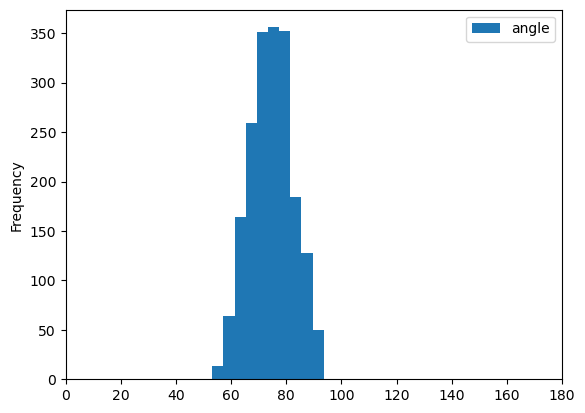

In [165]:
#rows.plot.scatter(x="angle",y="norm_score",xlim=(0,180))
rows.plot.hist(y="angle",xlim=(0,180))

<Axes: ylabel='Frequency'>

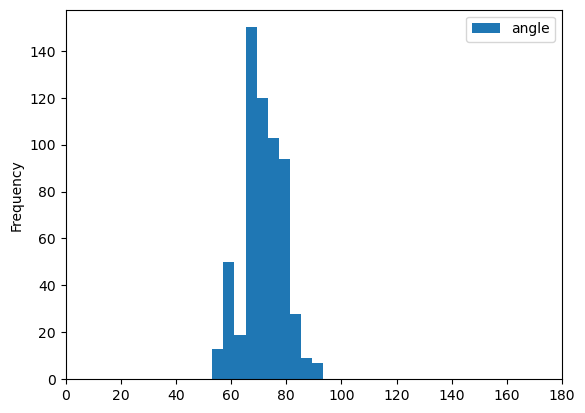

In [166]:
#rows.loc[rows["overlapped"]==False].plot.scatter(x="angle",y="norm_score", xlim=(0,180))
rows.loc[rows["overlapped"]==False].plot.hist(y="angle",xlim=(0,180))

In [167]:
len(rows),len(rows.loc[rows["overlapped"]==False])

(1921, 593)

In [171]:
#iter = range(0,11)
iter = tqdm(range(0,11))
for i in iter:
    print(i)

  0%|          | 0/11 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
